# Simulation Study of a Branching Process and Re-Parameterization Case Study

#### MSDS 7333 - Quantifying the World - 04/06/17
#### Author: James Tsai, Wid Sogata     
===========================================================================================

Write a report on your analysis, including introduction, background, methods, results, and conclusions/discussions. 


### Abstract
In this case study, we are studying the behavior of programs/jobs running on a CPU (or multiple CPUs in parallel). Mostly we follow the analysis method in the textbook until we arrive at the focus of the assignment, which is an investigation related to reducing parameters without changing outcomes.  
<br>
We are interested in the distribution of the completion time for the entire system. In particular, we wanted to know which combinations of job creation (Lambda) and job completion rates (Kappa) leads to processes that definitely complete in finite time (lifetime) and those that might never complete. Tsitsiklis et. al. and Aldous and Krebs studied this random processes of lifetime via mathematics, where they found analytic solutions to features of the process. To derive these results, they considered ways to simplify the complex problem to one where their analysis would still yield meaningful and potentially useful insights. Simulations can be used as a substitution for these analytic solutions when such solutions are hard to obtain. How the behavior of the process changes when the assumed behavior deviates, simulations can offer insights that might be difficult to obtain analytically. This simulation studies attempt to model a random process using the computer in order to provide insights about properties of the process.

#### Keywords
Branching Process, Poisson Random Process, Birth, Assassination, Lifetime, Tree, Random, Parent Child Process. 

### Introduction
Aldous and Krebs considered a variant of the branching process proposed byTsitsiklis et. al. The Aldous and Krebs process can be viewed as one where:
* The initial job generates other jobs with the times between the start of jobs independent and identically distributed.
* These offspring jobs must all wait until their parent program completes before they can start running.
* Each job can spawn jobs of its own as soon as it is generated.

An illustration of this system appears in Figure 1. There, the initial job generated 3 jobs. The first of these 3 jobs did not generate any jobs of its own, the second spawned 3 jobs, and the third generated 2, the first of which spawned 2 jobs. In this figure, the system of jobs is still running. The initial job has completed, as have its first 2 child jobs so they are marked with an X. The third child, marked R, is still running so its children and grandchildren are waiting for it to complete before they can begin to run (they are marked W). As for the children of the second subtask, one has completed and the other two are running. Each program that is running or waiting to begin to run (i.e., the R and W nodes in the tree) may generate additional jobs at a time in the future that we have not yet observed. Aldous and Krebs were interested in studying the behavior of the time it takes for the entire system of jobs to finish running, particularly, which combination of job creation
and job-completion rates leads to processes that definitely complete in a finite amount of time and which might never complete.

![image](fig1.png)
<center> Figure 1. Branching Process Tree Example.
<br>

In our analysis, we are particularly interested only in simulation study to see whether re-parameterization suggested in Section 7.9.1 in the textbook (question 10)  is appropriate. We want to see, for example, fix Kappa to be 1, and run the simulation for various values of Lambdas. We compare the results to other simulations where Kappa is not equal to 1, but the ratio of Lambda/Kappa matches one of the Lambda values from the simulation when Kappa was 1.


We are using R version 3.3.1 running on Jupyter Notebook to perform this analysis.

### Method

In designing this simulation study, the process begins with a certain number of jobs that lasts for a random amount of time. The completion time (often referred to as lifetime) is determined by some probability distribution. Typically the exponential distribution is used to model lifetimes, so we follow that approach here. The exponential distribution has a rate parameter, kappa(k), where the density is
<center> (k)exp^(−kx), x > 0 </center> 
<br>
According to Aldous and Krebs, births are to follow a Poisson process so we must figure out how to generate random values from a Poisson process. Poisson process is related to but different from the Poisson random variable. The process is a probability mechanism for generating random events in time, such as the starting times for jobs. The count of the number of events generated in a fixed time interval is a Poisson random variable, i.e.,
<center> P(k births in an interval of length 1) = ((Lambda^k)(k!^Lambda))/e, k = 0, 1, 2, ...  </center> 
<br>
A property of the Poisson process that we can use to generate births is that the time between each pair of consecutive events, which is called the inter-arrival time, has an exponential distribution and these inter-arrival times are independent of one another. This means that we can generate the inter-arrival times from the exponential distribution and piece them together to get the birth/start times of jobs. The initial job starts at time 0 so its first offspring’s birth date is the first inter-arrival time. That is, we generate the first offspring’s birth date as an exponential random outcome. Then, we generate the time between the birth of the first and second offspring with another independent realization from the exponential distribution, the time between the second and third offspring also has an exponential distribution independent of the others, and so on.
The process proposed by Aldous and Krebs says that once a program is spawned, it must wait until its parent completes before it begins running, and its run time follows the same distribution as its parent’s. This means that we can think of each job’s lifetime as consisting of two distinct parts.
* The time that the job’s parent lives, and it waits to begin running.
* The time that the job lives beyond its parent, when it runs.       

This two-part lifetime is why Aldous and Krebs dubbed the process a birth and assassination process. The idea is that the children in the process are protected by their parent. When the parent lives, its children cannot die, but once the parent is assassinated, then the children are no longer protected and they now can be assassinated. The time when they are unprotected and can be assassinated is the job’s run time.
More formally, we can think of each child as living a certain random amount of time past the death of its parent. This time is treated as an independent increment past the parent’s death, and we model it with the same exponential distribution as the original job’s lifetime with rate Kappa.

#### Generating Offspring and Simulating Branching Process


From the above, we have identified a task that we would like to encapsulate in a function – generating
random birth times and the corresponding completion times of a job’s offspring. The following are the parametes that we need for this function:   

* The parent’s birth time (bTimes)
* Completion/death time in order to generate its offspring’s lifetimes, so these two times should be input parameters to our function (cTimes).
* The rate for the inter-arrival of the offspring (Lambda)
* A rate for the run times of the offspring in order to parameterize the exponential distributions for the birth and completion times (Kappa).

We want to parameterize these values so they can be easily modified when we study their impact on the longevity of the process. We now have identified 4 parameters for our function definition.
Let’s consider how we might generate all of the offspring for one generation. Suppose as before that the parent has a birth time of bTime and a completion time of cTime, then the number of offspring that this job has can be generated with      
<br>
<center> numKids = rpois(1, lambda = (cTime - bTime) * lambda) </center>   

Once we have the number of offspring for each parent, we can generate the times for birth and completion of the offspring with mapply(),
Note that kidStats is a list where each element contains the birth times of a job’s children.
We also must generate the completion time for these children. We can do this within the function provided in mapply().

In [1]:
seed = 12062013
set.seed(seed)

In [2]:
genKidsV = function(bTimes, cTimes, parentID, lambda = 0.5, kappa = 0.3) {
  # Determine how many children each job has
  parentAge = cTimes - bTimes
  numKids = rpois(n = length(parentAge), lambda = lambda * parentAge)
  
  if (sum(numKids) == 0) return(NULL)
  
  # Determine the birth times of the children  
  kidStats = 
    mapply(function(n, min, max) {
      births = sort(runif(n, min, max))
      runtimes = rexp(n, rate = kappa)
      completes = rep(max, n) + runtimes
      data.frame(births, completes)
    },
           n = numKids , min = bTimes, max = cTimes, 
           SIMPLIFY = FALSE)
  
  return(data.frame(parentID = rep(parentID, numKids),
                   # kidID = 1:sum(numKids),
                    kidID = 1:sum(numKids),
                    births = unlist(lapply(kidStats, "[[", "births")), 
                    completes = unlist(lapply(kidStats,"[[", "completes"))
                    ))
}

We are now ready to generate the whole process. Depending on the parameter values for Lambda and Kappa, the process may continue on indefinitely or it may complete in a finite amount of time. In oreder to simulate this process, we can’t let the process run forever if it is never going to complete. To control the process that runs forever or a long time, we could run it for a fixed number of generations and if the process has not completed, then we terminate it. We could run it until we have generated a fixed number of offspring or we could run the simulation for a fixed amount of time. Additionally, we might check more than one of these approaches to decide whether or not to terminate the process. Our choice in part depends on the way we have implemented the process. With the current implementation, we can create an entire generation with one call to genKidsV so it makes sense to start by capping the number of generations. Consequently, the number of offspring in a generation could become large, but we will try this approach and see how well it controls the process. 
<br>

To simulate the process, we need to call the genKidsV() function for each successive generation and collect the return value from each call. We first get the process started with the single, lead job, and then we successively call genKidsV() for the specified number of generations. We also need to check to make sure that the process hasn’t terminated before we ask genKidsV() to produce the next generation. Our input parameters to this function are the original Lambda and Kappa rates for the Poisson and exponential random variables, and the limit on the number of generations to simulate. As for the return value, a list of generations will be provided.

In [3]:
familyTree = function(lambda = 0.5, kappa = 0.3, 
                      maxGen = 10, maxOffspring = 1000) {
  
  # Return value - a list with 1 data frame per generation.
  allGens = vector(mode = "list", length = maxGen)
  
  # Generate root of the tree
  allGens[[1]] = data.frame(parentID = NA, kidID = 1, 
                            births = 0, 
                            completes = rexp(1, rate = kappa))
  
  currentNumOffspring = 0

  # Generate future generations, one at a time.
  for (i in 2:maxGen) {
    nextGen = genKidsV(bTimes = allGens[[ (i - 1) ]]$births,
                       cTimes = allGens[[ (i - 1) ]]$completes,
                       parentID = allGens[[ (i - 1) ]]$kidID,
                       lambda = lambda, kappa = kappa)
    if (is.null(nextGen)) return(allGens[ 1:(i - 1) ]) 
    allGens[[ i ]] = nextGen
    currentNumOffspring = currentNumOffspring + nrow(nextGen)
    if (currentNumOffspring > maxOffspring) 
      return(allGens[1:i])
  }  
  allGens
 }

We can create a visualization to inspect the branching tree. The following code provides a plot of the contents of
tree. It represents each job as a line segment and marks the birth of each job’s children with an X on the segment. We set the process completed in 4 generations and that there are maximum 10 generations in this instance of the process.

Warning message in is.na(nextGen$births):
"is.na() applied to non-(list or vector) of type 'NULL'"

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

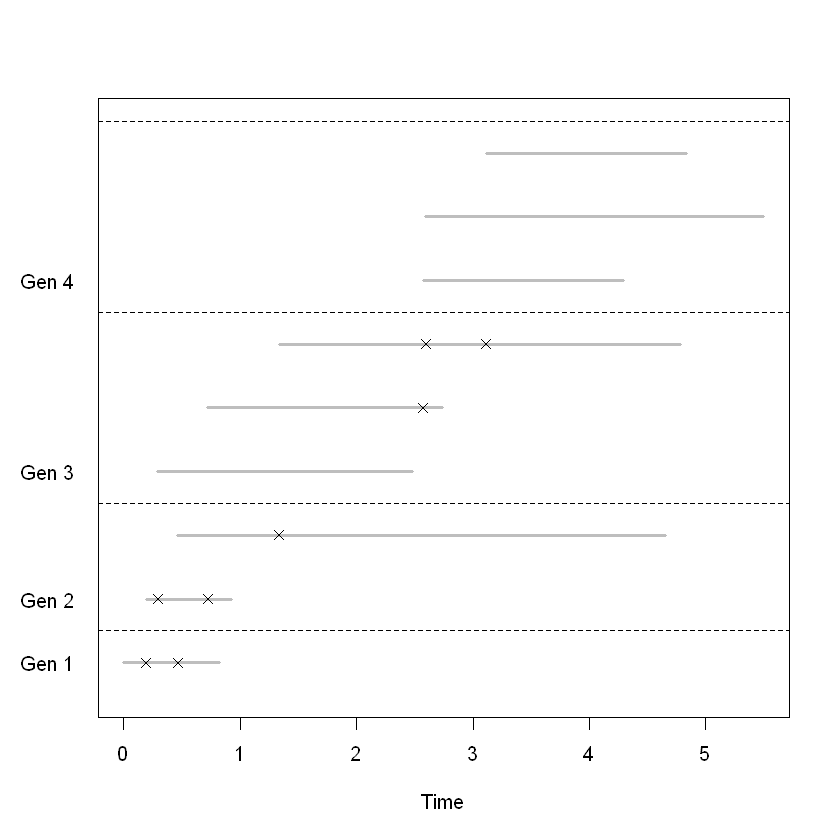

In [4]:
g = familyTree(lambda = 0.4, kappa = 1, maxGen = 10)

maxLife = max(sapply(g, function(gen) max(gen$completes)))
numFamily = sum(sapply(g, nrow))

plot(0,0, ylim = c(0.5, numFamily + 0.5), xlim = c(0, maxLife),
     xlab = "Time", ylab = "", type ="n",
     axes = FALSE)

box()
axis(1)
numGen = length(g)
numKids = sapply(g, nrow)
treeN = g[ 2:(numGen + 1) ]
birthNum = c(0, cumsum(sapply(g, nrow))[ -length(g)])
axis(2, at = birthNum + 1, 
     labels = paste("Gen", 1:numGen), tick = FALSE, las = 1)

mapply(function(gen, nextGen, birthNum) {
  birthOrder = birthNum + (1:nrow(gen))
  segments(x0 = gen$births, x1 = gen$completes, y0 = birthOrder,
          lwd = 3, col = "grey")
  abline(h = 0.5 + max(birthOrder), lty = 2, col="black" )
  if (all(!is.na(nextGen$births)))
  points(x = nextGen$births, y = birthOrder[nextGen$parentID],
         pch = 4)
  },
  gen = g, nextGen = treeN, birthNum = birthNum )


<center> Figure 2. Visualization of a Randomly Generated Branching Process. </center>   

Figure 2 plot shows the lifetimes of each member of a randomly generated birth and assassination process with a birth rate of Lambda = 0.4 and a completion rate of Kappa = 1. Each job’s lifetime is represented by a grey line segment with endpoints at its birth and completion times. The Xs on the segment denote the birth times of the job’s offspring. The dashed lines separate the generations. We see that the process completed in 4 generations and that there are 9 jobs in this instance of the process. None of the jobs in the fourth generation of this instance of the process had offspring so the process terminated there. Notice that one job in the second generation ran for a very long time and had just one child. 

##### Replicating The Simulation with Various Parameters

We are now ready to study the branching process for various combinations of the parameter values Lambda and Kappa. To do this, we want to automate the call to familyTree(). Since it can easily become unwieldy to save the thousands of lists of data frames from each observed process, we want to store only relevant summaries. We have been examining the process through
its number of generations and number of jobs. The following simple function exptOne calls familyTree() and summarizes the return value by these two simple summaries

In [5]:
seed2 = 12212013
set.seed(seed2)

exptOne = function(l, k, mG, mO){
      
  # Helper function to call familyTree
  # Returns - summary statistics for analysis, 
  aTree = familyTree(lambda = l, kappa = k, maxGen = mG,
                      maxOffspring = mO)
  numGen = length(aTree)
  numJobs = sum(sapply(aTree, nrow))
  c(numGen, numJobs)
}

We obtain the same summary statistics from our earlier call to familyTree(). We want to call exptOne() many times for each of several values of Lambda and Kappa. We can specify the number of replications and the values for Lambda and Kappa via a
function that calls exptOne(),

In [6]:
MCBA = function(params, repeats = 5, mG = 10, mO = 1000){
    
 # params: matrix columns of lambda and kappa values
 # For each lambda and kappa pair, run "repeats" times
  n = nrow(params)
  mcResults = vector("list", length = n)
  
  for (i in 1:n) {
    mcResults[[i]] = replicate(repeats,
                               exptOne(l = params[i, 1],
                                       k = params[i, 2],
                                       mG = mG, mO = mO))
  }
  mcResults
}

Next we need to find valu range  of Lambda and Kapp for our simulation study? We can try a few values to determine a feasible region of the parameter space.

In [7]:
trialKappas = c(0.1, 10, 0.1, 10)
trialLambdas = c(0.1, 0.1, 10, 10)
trialParams = matrix(c(trialLambdas, trialKappas), ncol = 2)
mcTrialOutput = MCBA(params = trialParams, repeats = 100, 
                     mG = 200, mO = 100000)

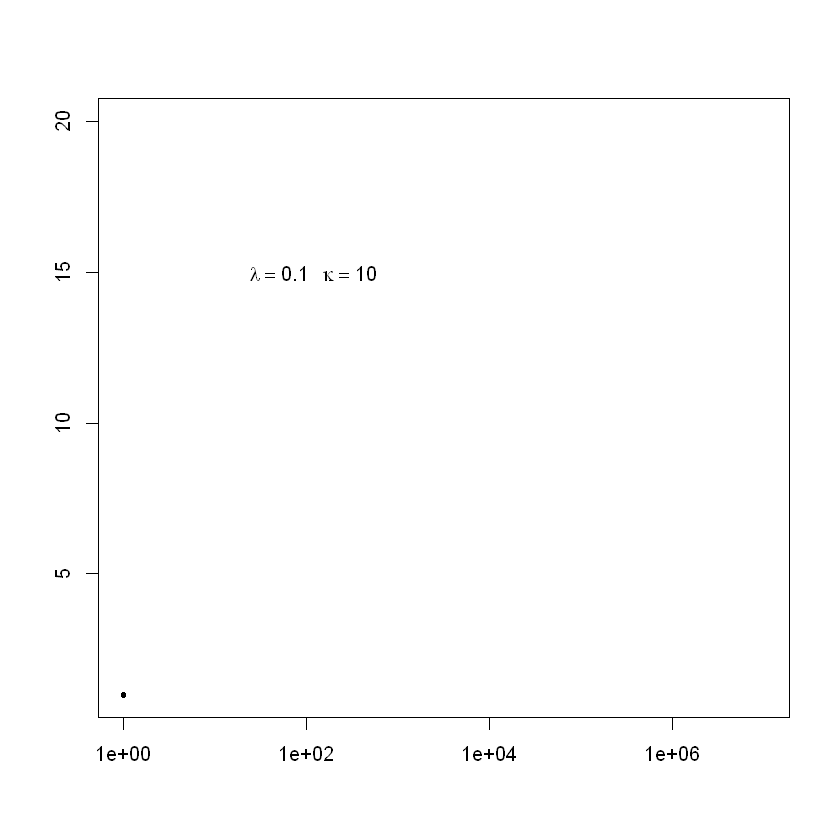

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

In [8]:
mapply(function(oneSet, lambda, kappa) {
  plot(x = oneSet[2,], y = jitter(oneSet[1, ], 1), 
       xlab = " ", ylab= " ", log = "x",
       ylim = c(1,20), xlim = c(1, 10^7), pch = 19, cex = 0.6)
  text(x = 50, y = 15, bquote(paste(lambda == .(lambda))) )
  text(x = 300, y = 15, bquote(paste(kappa == .(kappa))) )
  }, 
  mcTrialOutput, lambda = trialLambdas, kappa = trialKappas)

<center> Figure 3. Scatterplots of the Number of Generations Against the Number of Offspring.</center>
<br>
These 4 scatter plots show the different behavior exhibited by the branching process as Lambda and Kappa vary. Each simulation terminates when the process dies out or one of the following limits is reached: 200 generations; 100,000 offspring. One hundred simulations are run for each (Lambda, Kappa) pair.

In [9]:
lambdas = c(seq(0.1, 0.6, by = 0.1), seq(0.8, 2, by = 0.2), seq(2.25, 3, by = 0.25))
kappas = c(lambdas, 3.25, 3.50, 3.75, 4.00, 4.50, 5.00)

paramGrid = as.matrix(expand.grid(lambdas, kappas))
colnames(paramGrid) = c("Lambda", "Kappa")
paramGrid

Lambda Kappa
 [1,] 0.10   0.1  
 [2,] 0.20   0.1  
 [3,] 0.30   0.1  
 [4,] 0.40   0.1  
 [5,] 0.50   0.1  
 [6,] 0.60   0.1  
 [7,] 0.80   0.1  
 [8,] 1.00   0.1  
 [9,] 1.20   0.1  
[10,] 1.40   0.1  
[11,] 1.60   0.1  
[12,] 1.80   0.1  
[13,] 2.00   0.1  
[14,] 2.25   0.1  
[15,] 2.50   0.1  
[16,] 2.75   0.1  
[17,] 3.00   0.1  
[18,] 0.10   0.2  
[19,] 0.20   0.2  
[20,] 0.30   0.2  
[21,] 0.40   0.2  
[22,] 0.50   0.2  
[23,] 0.60   0.2  
[24,] 0.80   0.2  
[25,] 1.00   0.2  
[26,] 1.20   0.2  
[27,] 1.40   0.2  
[28,] 1.60   0.2  
[29,] 1.80   0.2  
[30,] 2.00   0.2  
[31,] ...    ...  
[32,] 0.50   4.5  
[33,] 0.60   4.5  
[34,] 0.80   4.5  
[35,] 1.00   4.5  
[36,] 1.20   4.5  
[37,] 1.40   4.5  
[38,] 1.60   4.5  
[39,] 1.80   4.5  
[40,] 2.00   4.5  
[41,] 2.25   4.5  
[42,] 2.50   4.5  
[43,] 2.75   4.5  
[44,] 3.00   4.5  
[45,] 0.10   5.0  
[46,] 0.20   5.0  
[47,] 0.30   5.0  
[48,] 0.40   5.0  
[49,] 0.50   5.0  
[50,] 0.60   5.0  
[51,] 0.80   5.0  
[52,] 1.00   5.0  
[53,] 1.20   5.0  
[54,] 1.40   5.0  
[55,] 1.60   5.0  
[56,] 1.80   5.0  
[57,] 2.00   5.0  
[58,] 2.25   5.0  
[59,] 2.50   5.0  
[60,] 2.75   5.0  
[61,] 3.00   5.0

<center> Table 1. Combination Values of Lambda and Kappa. </center>

We call MCBA() with the matrix of parameter values and the limitations on the size of the tree. Note that for each (Lambda, Kappa) pair, 400 instances of the process are generated. We can summarize our simulation by, e.g., plotting the upper quartile of number of offspring in each of the 400 replications. Since we have 3 variables (Lambda, Kappa, and the number of offspring), we make a 3-dimensional scatter plot. We also use color to distinguish between trees that die out and those that surpass the 1,000 offspring limit.

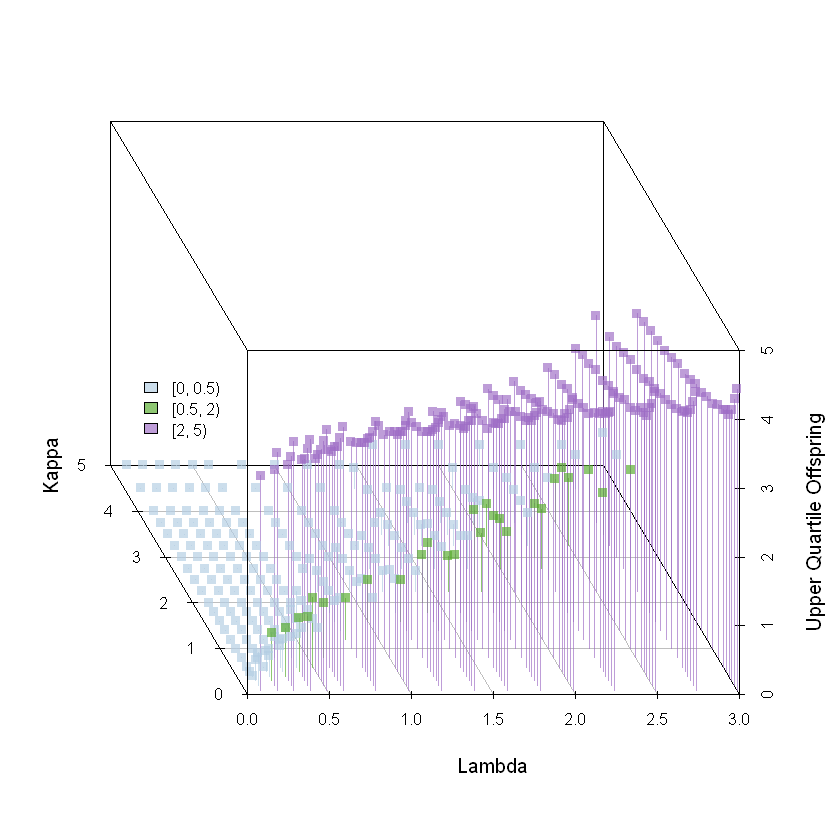

In [10]:
mcGrid = MCBA(params = paramGrid, repeats = 400, mG = 20,
                mO = 1000)

logUQkids = sapply(mcGrid, function(x) 
               log(quantile(x[2, ], probs = 0.75), base = 10))

UQCut = cut(logUQkids, breaks = c(-0.1, 0.5, 2, max(logUQkids)) )
color3 = c("#b3cde3aa", "#56ab2caa", "#9d6cc5aa")
colors = color3[UQCut]

library(scatterplot3d)
sdp = scatterplot3d(x = paramGrid[ , 1], y = paramGrid[ , 2], 
                   z = logUQkids, pch = 15, color = colors,
                    xlab = "Lambda", ylab = "Kappa",
                    zlab = "Upper Quartile Offspring",
                    angle = 120, type="h")

legend("left", inset = .08, bty = "n", cex = 0.8,
       legend = c("[0, 0.5)", "[0.5, 2)", "[2, 5)"), 
       fill = color3)

<center> Figure 4. Three-Dimensional Scatterplot of the Number of Offspring by Lambda and Kappa.</center>    

Figure 4 shows the results. Each point in this scatter plot represents the upper quartile of the number of offspring in 400
random outcomes of the branching process for a particular (Lambda, Kappa) pair. The offspring are plotted on log base 10 scale, so the first category, i.e., [0, 0.5) corresponds to 1 to 3 offspring.  

We see that nearly all of the simulated processes where Kappa is small are still alive at the time we stopped the simulation and nearly all of the simulated processes for small Lambda values terminate before the limitations are reached. Also noticeable is the pale diagonal region in the plot where those pairs below this region are more likely than not to still be running and those above the diagonal are less likely than not to have completed.   
Another measure of longevity that we can examine is the proportion of simulations that have 20 or more offspring. The simulation is run for at most 20 generations, so this seems like a reasonable threshold to examine.

### Simulation with Reduced Parameter 
With these visual summaries of the simulation study, we see that the relationship between Lambda and Kappa is key to the longevity of the process. For example, when Kappa > Lambda, the process dies out within a few generations. There appears to be a region where the process at times produces many thousands of children and seems to carry on indefinitely, and other regions (e.g., where Lambda is small) when the process never terminates, or nearly so. The plots we have
made suggest that we may be able to parameterize the process in terms of the ratio Lambda/Kappa and work with only one parameter. This observation suggests alternative visualization for these simulation results may be useful to examine. If we want to carry out more simulations to further investigate this property, we can do this without modifying our code as we can
simply set Kappa to 1.

In [11]:
lambdas = c(seq(0.1, 0.6, by = 0.1), seq(0.8, 2, by = 0.2), seq(2.25, 3, by = 0.25))
kappas = 1

paramGrid = as.matrix(expand.grid(lambdas, kappas))
colnames(paramGrid) = c("Lambda", "Kappa")
paramGrid

Lambda Kappa
 [1,] 0.10   1    
 [2,] 0.20   1    
 [3,] 0.30   1    
 [4,] 0.40   1    
 [5,] 0.50   1    
 [6,] 0.60   1    
 [7,] 0.80   1    
 [8,] 1.00   1    
 [9,] 1.20   1    
[10,] 1.40   1    
[11,] 1.60   1    
[12,] 1.80   1    
[13,] 2.00   1    
[14,] 2.25   1    
[15,] 2.50   1    
[16,] 2.75   1    
[17,] 3.00   1

<center> Table 2. Combination Values of Various Lambda and a Constant Kappa of 1. </center>

Without modifying the code as suggested by the author of the textbook, we see that the suggestion in Section 7.9.1 in the textbook (question 10) is appropriate. With fix constant Kappa of 1, we run the simulation for various values of Lambdas. We found that the relationship between Lambda and Kappa is consistent as key to the longevity of the process.  This observation suggests that alternative visualization for these simulation is useful to examine. We can carry out more simulations to further investigate this property, by setting Kappa to 1.

In [12]:
mcGrid = MCBA(params = paramGrid, repeats = 400, mG = 20,
                mO = 1000)

logUQkids = sapply(mcGrid, function(x) 
               log(quantile(x[2, ], probs = 0.75), base = 10))

UQCut = cut(logUQkids, breaks = c(-0.1, 0.5, 2, max(logUQkids)) )

color3 = c("#b3cde3aa", "#56ab2caa", "#9d6cc5aa")
colors = color3[UQCut]

library(scatterplot3d)
sdp = scatterplot3d(x = paramGrid[ , 1], y = paramGrid[ , 2], 
                   z = logUQkids, pch = 15, color = colors,
                    xlab = "Lambda", ylab = "Kappa",
                    zlab = "Upper Quartile Offspring",
                    angle = 120, type="h")

legend("left", inset = .08, bty = "n", cex = 0.8,
       legend = c("[0, 0.5)", "[0.5, 2)", "[2, 4)"), 
       fill = color3, title = "Upper Quartile Offsprings (in Log10)")

<center> Figure 5. Three-Dimensional Scatterplot of the Number of Offspring by Various Lambda Values and a Constant Kappa of 1.</center> 

To have consistent outcome of this simulation compare to the previous.  We see when Kappa is a lot higher than Lambda (Lambda << 1), the process dies out within a few generations and less offsprings. In the mid region, when the ratio is approaching 1 (0.7 to 1.5), it produces in tens at the lower end and as the ratio gets higher, it produces many thousands of children and seems to carry on indefinitely. And the regions where Lambda is high, the process never terminates, or nearly so.
<br>

Further we display the observation in 2D model and again use the ratio of Lambda/Kappa as one parameter and the offspring as the other. 

In [13]:
mcGrid = MCBA(params = paramGrid, repeats = 400, mG = 20,
                mO = 1000)

logUQkids = sapply(mcGrid, function(x) 
               log(quantile(x[2, ], probs = 0.75), base = 10))

UQCut = cut(logUQkids, breaks = c(-0.1, 0.5, 2, max(logUQkids)) )

pch3 = c(1, 7, 24)
pch =  pch3[UQCut]
    
lambda = paramGrid[ , 1]
kappa = paramGrid[ , 2]

sdp = plot(lambda/kappa, logUQkids, 
           pch = pch, 
           xlab = "Lambda/Kappa", ylab =  "Upper Quartile Offspring")

legend("left", inset = .08, bty = "n", cex = 0.8,
       legend = c("[0, 0.5)", "[0.5, 2)", "[2, 4)"), 
       pch = pch3, title = "Upper Quartile Offsprings (in Log10)")

<center> Figure 6. Two-Dimensional Scatterplot of the Number of Offspring by the Ratio of Lambda and Kappa.</center>   


In Figure 5, we see clearer picture of this simulation. We see when the ratio is a lot lower than 1, the process dies out within a few generations and much less offsprings (10^0 to 10^0.5 offsprings). In the mid region when the ratio is higher, the process at times produces many thousands of children (10^0.7 to 10^3 offsprings)and seems to carry on indefinitely, and regions where the ratio is high, the process may never terminates, or nearly so (> 10^3 offsprings)

### Conclusion and Future Works





This observation suggests alternative visualization for these simulation results may be useful to examine. One of the key benefits of data visualization is how it enables users to more effectively see connections as they are occurring between operating conditions and the outcomes. It has an amazing ability to make the complex simple, and the available tools can do much more than give everyone the same view of data. In many cases, only through visualization that we can take something as abstract as symbols and turn it into a physical observations that has dimensions that our eyes can quickly see and understand. We can grasp data’s meaning more quickly. Visualization also can tell us when trends are heading in the wrong direction and when we need to intervene.
Additionally, simplifying or reducing the number of parameters, as long as it does not affect the behaviour of the outcomes, is recommended. A simplification is one possible solution to view this problem. By transforming more complex visualizaton, into more simple one, we can see clearer picture and even faster processes (less resource). It also reduces the barrier between users and their observations. 

If we want to carry out more simulations to further investigate this property, we can try with different method of simulations such as multiple branching process at a time in vectorized fashion. A different custom visualization is possible as well.

### References

Nolan, D. & Lang, T. L. (2015) Data Science in R. A Case Studies Approach to Computational Reasoning and Problem Solving. Boca Raton, FL: CRC Press.  
Wickham, W. & Grolemund, G. (2015) R for Data Science. Sebastopol, CA: OReilly Media, Inc.   
Case Studies in Data Science with R, Retrieved March 24, 2017, from http://rdatasciencecases.org/   
Aldous, D & Krebs, W. (1990) The Birth and Assassination Process. Statistics and Probability Letters. North Holland, Elsevier. 